# Prepare Data
Here we prepare data as 1 min level kline for BTC from 2019.1.1 to 2020.5.2 in bitfinex exchange

In [1]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm, trange

In [2]:
TZ = 'Asia/Shanghai'

In [3]:
data_path = './data/data'
data_platform_list = ['BITFINEX']
data_symbol_list = ['BTC']

data_df_list = []

In [4]:
for platform in data_platform_list:
    for symbol in data_symbol_list:
        pkl_file_path = data_path+'/'+symbol+'_USD_'+platform+'_latest.pkl'
        pandas_df = pd.read_pickle(pkl_file_path)
        #data_df_list.append(pkl_file.add_prefix(platform+'_'+symbol+':'))
        data_df_list.append(pandas_df)
data = pd.concat(data_df_list, axis=1)

# Feature Enginnering

Tactical indicators etc.

In [5]:
data['timestamp'] = data.index.tolist()

In [6]:
data

,open,high,low,close,volume,timestamp
2019-01-01 16:00:00+08:00,3850.000000,3850.000000,3849.600000,3849.600000,0.443293,2019-01-01 16:00:00+08:00
2019-01-01 16:01:00+08:00,3849.500000,3853.000000,3849.400000,3853.000000,9.085920,2019-01-01 16:01:00+08:00
2019-01-01 16:02:00+08:00,3853.000000,3857.000000,3852.960000,3853.200000,8.213360,2019-01-01 16:02:00+08:00
2019-01-01 16:03:00+08:00,3853.000000,3853.100000,3851.200000,3852.200000,6.385190,2019-01-01 16:03:00+08:00
2019-01-01 16:04:00+08:00,3852.200000,3852.300000,3852.200000,3852.300000,0.504622,2019-01-01 16:04:00+08:00
...,...,...,...,...,...,...
2020-11-07 15:55:00+08:00,15428.349581,15437.000000,15428.000000,15436.374894,1.040375,2020-11-07 15:55:00+08:00
2020-11-07 15:56:00+08:00,15434.000000,15447.000000,15434.000000,15443.000000,5.073000,2020-11-07 15:56:00+08:00
2020-11-07 15:57:00+08:00,15441.000000,15446.000000,15441.000000,15446.000000,1.608000,2020-11-07 15:57:00+08:00
2020-11-07 15:58:00+08:00,15443.786243,15443.786243,15430.460723,15430.460723,0.692501,2020-11-07 15:58:00+08:00


In [7]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 


# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 

In [8]:
feature_set = ['ma5m','ma10m','ma1h','ma4h','ma12h','ma1d','ma5d','ma10d','ma30d', \
               'std5m','std10m','std1h','std4h','std12h','std1d','std5d','std10d','std30d',\
               'dis100', 'dis1000']

## Augment with same features in previous timestamps

In [9]:
new_feature_set = []
for feature in feature_set:
    data[f'{feature}_p1h'] = data[feature].shift(60)
    data[f'{feature}_p1d'] = data[feature].shift(1440)
    data[f'{feature}_p5d'] = data[feature].shift(7200)
    new_feature_set += [feature, f'{feature}_p1h', f'{feature}_p1d', f'{feature}_p5d']
feature_set = new_feature_set

In [10]:
print(f'Total feature number {len(feature_set)}')

Total feature number 80


## Show distribution of return in 1d 

(array([9.00000e+00, 5.60000e+01, 3.20000e+02, 1.95000e+02, 5.63000e+02,
        1.26600e+03, 3.88500e+03, 5.75400e+03, 1.41590e+04, 4.26120e+04,
        1.28025e+05, 3.82767e+05, 2.44936e+05, 6.97350e+04, 2.83680e+04,
        8.85600e+03, 6.13100e+03, 3.09700e+03, 1.18700e+03, 2.61000e+02,
        2.04000e+02, 1.23000e+02, 1.93000e+02, 2.68000e+02, 1.59000e+02,
        1.02000e+02, 9.70000e+01, 9.90000e+01, 6.60000e+01, 6.70000e+01,
        4.30000e+01, 8.80000e+01, 5.00000e+01, 3.00000e+01, 2.20000e+01,
        1.20000e+01, 1.00000e+01, 4.10000e+01, 4.10000e+01, 4.00000e+01,
        1.10000e+01, 3.00000e+00, 2.00000e+00, 4.00000e+00, 1.20000e+01,
        9.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.28686676, -0.26269117, -0.23851558, -0.21433999, -0.19016441,
        -0.16598882, -0.14181323, -0.11763764, -0.09346206, -0.06928647,
        -0.04511088, -0.0209353 ,  0.00324029,  0.02741588,  0.05159147,
         0.07576705,  0.09994264,  0.12411823,  0

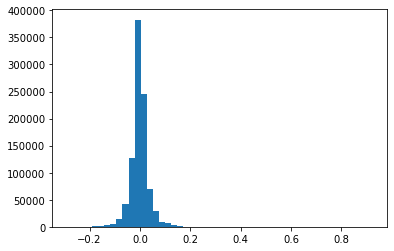

In [11]:
plt.hist(data['close'] / data['close'].shift(-1440) - 1,bins=50)

In [12]:
data['up_x%_in_1d_label'] = 100 * (data['close'] / data['close'].shift(-60) - 1)

In [13]:
data=data.dropna()

## Data Preparation

In [14]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2019-12-31', tz=TZ)
val_start_time = pd.Timestamp('2020-01-01', tz=TZ)
val_end_time = pd.Timestamp('2020-06-01', tz=TZ)
test_start_time = pd.Timestamp('2020-06-01', tz=TZ)
test_end_time = pd.Timestamp('2020-11-01', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

## Discritize continuous features

In [15]:
X_train = train_data[feature_set].values.squeeze().astype(np.float32)
X_val = val_data[feature_set].values.squeeze().astype(np.float32)
X_test = test_data[feature_set].values.squeeze().astype(np.float32)

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(X_train)

KBinsDiscretizer(encode='ordinal', strategy='uniform')

In [18]:
X_train = est.transform(X_train)
X_val = est.transform(X_val)
X_test = est.transform(X_test)

## Construct labels

In [19]:
label = ['up_x%_in_1d_label']

positive_threshold = 1

#Train
y_train = (train_data[label].values > positive_threshold).astype(int)
y_train_soft = np.zeros((len(y_train),2))
y_train_soft[:,1] = np.clip(1 + train_data[label].values.squeeze() - positive_threshold, 0, 1)
y_train_soft[:,0] = 1 - y_train_soft[:,1]

#Val
y_val = (val_data[label].values > positive_threshold).astype(int)
y_val_soft = np.zeros((len(y_val),2))
y_val_soft[:,1] = np.clip(1 + val_data[label].values.squeeze() - positive_threshold, 0, 1)
y_val_soft[:,0] = 1 - y_val_soft[:,1]

#Test
y_test = (test_data[label].values > positive_threshold).astype(int)
y_test_soft = np.zeros((len(y_test),2))
y_test_soft[:,1] = np.clip(0.5 + (test_data[label].values.squeeze()-positive_threshold), 0, 1)
y_test_soft[:,0] = 1 - y_test_soft[:,1]

In [20]:
print(f'Positive ratio in train set: {np.sum(y_train) / y_train.size}')
print(f'Positive ratio in val set: {np.sum(y_val) / y_val.size}')
print(f'Positive ratio in test set: {np.sum(y_test) / y_test.size}')

Positive ratio in train set: 0.045081318681318684
Positive ratio in val set: 0.05734429648496258
Positive ratio in test set: 0.01931468867245056


### Initialize Sample Reweighting & Feature Selection

In [21]:
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
from sample_reweight import SampleReweight
from featureSelection import featureSelection

In [23]:
LIMITED_SAMPLE = False
EXAMPLES = 40000 if LIMITED_SAMPLE else X_train.shape[0]

# number of submodels
K = 5

# initialize sample weights and parameters
w = np.ones(X_train.shape[0])[:EXAMPLES]

ALPHA_1 = 1
ALPHA_2 = 1
NUM_BINS = 10
GAMMA = 0.9

# initialize feature selection parameters
NUM_BINS_FS = 3
ratio = [0.8, 0.6, 0.4]
feature_selected = np.arange(len(feature_set))

### Single model

In [24]:
model_single = GradientBoostingClassifier(random_state=0)
model_single.fit(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES].squeeze(), sample_weight=w)

GradientBoostingClassifier(random_state=0)

### 5 submodels

In [25]:
clfs_5_sub = []

for i in tqdm(range(K)):
    clfs_5_sub.append(GradientBoostingClassifier(random_state=0))
    clfs_5_sub[i].fit(X_train[:EXAMPLES], y_train[:EXAMPLES].squeeze(), sample_weight=w)

### +SR

In [ ]:
clfs_SR = []

for i in tqdm(range(K)):
    clfs_SR.append(GradientBoostingClassifier(random_state=0))
    clfs_SR[i].fit(X_train[:EXAMPLES], y_train[:EXAMPLES].squeeze(), sample_weight=w)
    
    staged_pred = []
    
    for j, pred in enumerate(clfs_SR[i].staged_predict_proba(X_train[:EXAMPLES])):
        staged_pred.append(np.log(pred))
    # initialize sample reweighting
    SR = SampleReweight(X_train[:EXAMPLES], y_train[:EXAMPLES], a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(clfs_SR[i], staged_pred)
    print(np.max(w))

### +SR+FS

In [ ]:
clfs_SR_FS = []

list_feature_selected = []
list_feature_selected.append(feature_selected.copy())

for i in tqdm(range(K)):
    clfs_SR_FS.append(GradientBoostingClassifier(random_state=0))
    clfs_SR_FS[i].fit(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES].squeeze(), sample_weight=w)
    
    staged_pred = []
    
    for j, pred in enumerate(clfs_SR_FS[i].staged_predict_proba(X_train[:EXAMPLES, feature_selected])):
        staged_pred.append(np.log(pred))
    # initialize sample reweighting
    SR = SampleReweight(X_train[:EXAMPLES, feature_selected], y_train[:EXAMPLES], a1=ALPHA_1, a2=ALPHA_2, b=NUM_BINS, gamma=GAMMA)
    w = SR.reweight(clfs_SR_FS[i], staged_pred)
    print(np.max(w))
    
    #feature selection
    feature_selected_index = featureSelection(clfs_SR_FS[i], X_val[:EXAMPLES, feature_selected], y_val[:EXAMPLES], NUM_BINS_FS, ratio)
    feature_selected = feature_selected[feature_selected_index]
    print(feature_selected)
    list_feature_selected.append(feature_selected.copy())

## Evaluate Model

In [ ]:
decision_list = []
decision_list.append(model_single.decision_function(X_test))
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_single = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_single)

In [ ]:
decision_list = []
for i in range(K):
    decision_list.append(clfs_5_sub[i].decision_function(X_test))
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_5_sub = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_5_sub)

In [ ]:
decision_list = []
for i in range(K):
    decision_list.append(clfs_SR[i].decision_function(X_test))
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_SR = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_SR)

In [ ]:
decision_list = []
for i in range(K):
    decision_list.append(clfs_SR_FS[i].decision_function(X_test[:,list_feature_selected[i]]))
print(len(decision_list))
print(np.asarray(decision_list).shape)
y_score_SR_FS = np.mean(np.asarray(decision_list), axis = 0)
print(y_score_SR_FS)

In [ ]:
def plot_roc(labels, scores):
    lw = 2
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

In [ ]:
plot_roc(y_test, y_score_single)
plot_roc(y_test, y_score_5_sub)
plot_roc(y_test, y_score_SR)
plot_roc(y_test, y_score_SR_FS)